# MOT Temperature

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from astropy.io import fits
from scipy.optimize import curve_fit
from scipy.signal import savgol_filter

def load_file(dat_id):
    print('loading ',dat_id)
    # load camera data
    # cam_filename = data_folder + r'\{}.fits'.format(dat_id)
    cam_filename =r'{}.fits'.format(dat_id)
    hdul = fits.open(cam_filename, memmap=False)
    raw_data = hdul[0].data
    return raw_data

def twoD_Gaussian(x_tuple, amplitude, x0, y0, sigma_x, sigma_y, theta, offset):
    (x,y) = x_tuple
    a = (np.cos(theta)**2)/(2*sigma_x**2) + (np.sin(theta)**2)/(2*sigma_y**2)
    b = -(np.sin(2*theta))/(4*sigma_x**2) + (np.sin(2*theta))/(4*sigma_y**2)
    c = (np.sin(theta)**2)/(2*sigma_x**2) + (np.cos(theta)**2)/(2*sigma_y**2)
    g = offset + amplitude*np.exp( - (a*((x-x0)**2) + 2*b*(x-x0)*(y-y0) + c*((y-y0)**2)))
    return g.ravel()

def cloud_width(t, sigma_0, temp):
    return np.sqrt(abs(sigma_0**2 + 1.380649e-23*temp*t**2/(87.62*1.66054e-27)))



loading  test1_Wed Jun  8 2022_14.59.37
loading  test1_Wed Jun  8 2022_14.50.02


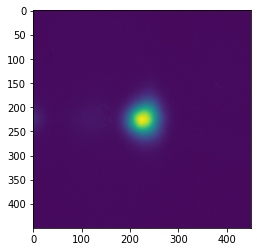

loading  test1_Wed Jun  8 2022_14.51.11


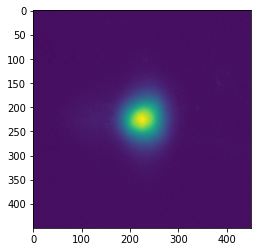

loading  test1_Wed Jun  8 2022_14.52.46


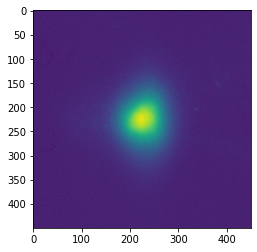

loading  test1_Wed Jun  8 2022_14.53.29


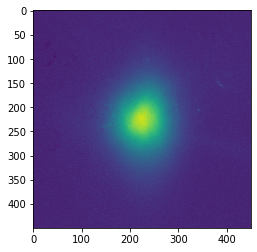

loading  test1_Wed Jun  8 2022_14.54.25


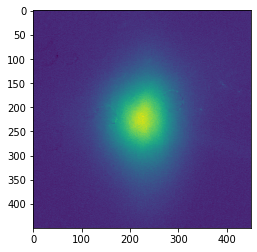

loading  test1_Wed Jun  8 2022_14.56.49


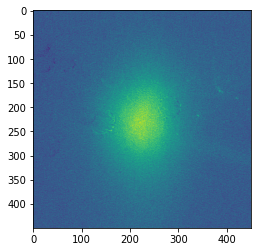

loading  test1_Wed Jun  8 2022_14.57.54


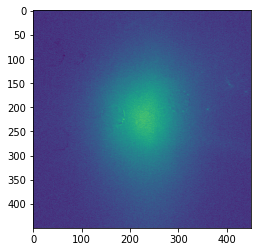

loading  test1_Wed Jun  8 2022_14.58.52


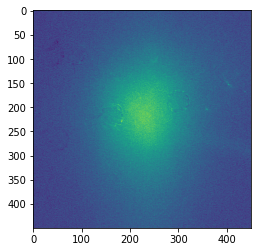

In [2]:
tof = [0.5,1.0,1.5,2.0,2.5,3.0,3.5,4.0] # Time-of-flight
fn = [50.02,51.11,52.46,53.29,54.25,56.49,57.54,58.52] # File's names
rd = [] # Raw data
photon_min = 0; photon_max = 30000; 
bg = load_file("test1_Wed Jun  8 2022_14.59.37").astype(np.int16) #Background
bg = np.clip(bg[0],photon_min, photon_max)
crop_size = 450 # crop the picture
for i in range(len(tof)):
    image = load_file("test1_Wed Jun  8 2022_14."+'%.2f'%(fn[i])).astype(np.int16)
    image = np.clip(image[0],photon_min, photon_max)
    image = image - bg + np.max(bg) # Subtract the background
    image_filter = savgol_filter(image, 51, 3) # Filter the data to find the peak of the atomic cloud
    position_max = np.where(image_filter == np.amax(image_filter)) # The index of the peak
    # Crop the picture around the peak
    crop = np.transpose(image[position_max[0][0]-int(crop_size/2):position_max[0][0]+int(crop_size/2)])[position_max[1][0]-int(crop_size/2):position_max[1][0]+int(crop_size/2)]
    plt.imshow(crop); plt.savefig("Image" + str(i) + ".jpg"); plt.show()
    rd.append(crop); 

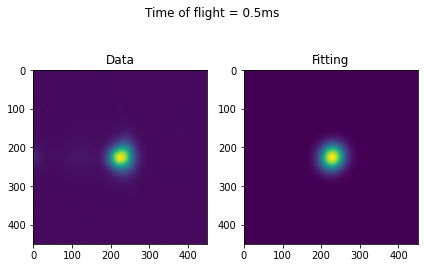

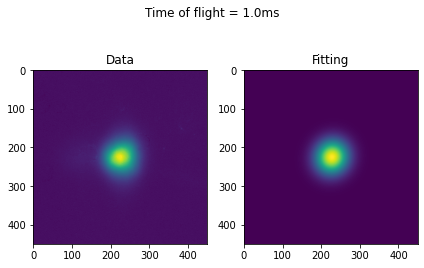

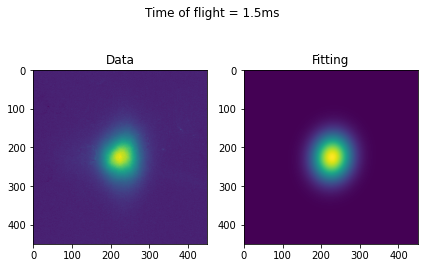

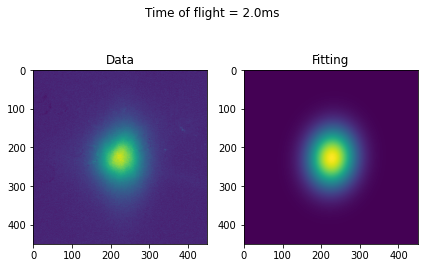

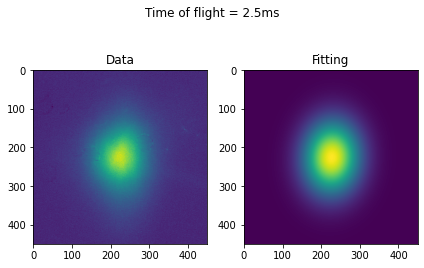

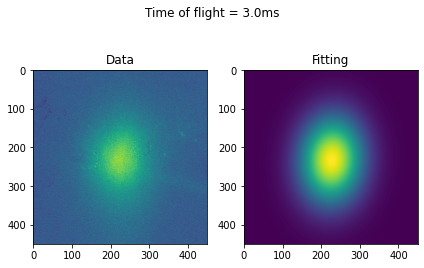

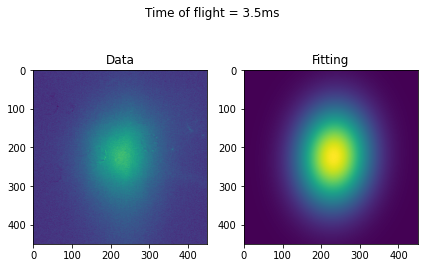

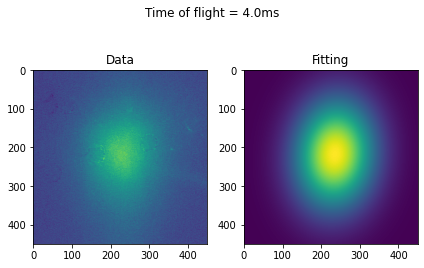

In [3]:
X = np.array(range(crop_size))
Y = np.array(range(crop_size))
X, Y = np.meshgrid(X,Y)
X_Y = (X,Y)
sigma_r = [] # Average width of MOT cloud
for i in range(len(tof)):
    fig, (ax1, ax2) = plt.subplots(1,2)
    params, cov = curve_fit(twoD_Gaussian, X_Y, rd[i].ravel())
    ax1.set_title('Data'); ax2.set_title('Fitting')
    ax1.imshow(rd[i]); ax2.imshow(twoD_Gaussian(X_Y, *params).reshape(crop_size,crop_size))
    fig.suptitle("Time of flight = "+str(tof[i])+"ms")
    plt.tight_layout(); plt.show();
    sigma_r.append((np.abs(params[3]) + np.abs(params[4]))/2)

Temperature of the MOT: 3.14 mK


Text(0, 0.5, 'Average MOT width [mm]')

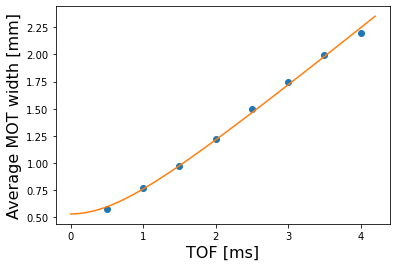

In [4]:
sigma_r_m = np.array(sigma_r)*26e-6 # The average spatial width of the atomic cloud in meter (2 pixel of camera is 26 micrometer)
tof_array = np.array(tof);
params_2, cov_2 = curve_fit(cloud_width,tof_array/1e3,sigma_r_m,p0=[0.5,0.002]);


t = np.linspace(0,4.2,1000);
print('Temperature of the MOT: %.2f mK' % (params_2[1]*1e3))
plt.plot(tof_array, sigma_r_m*1e3, 'o')
plt.plot(t, cloud_width(t/1e3,*params_2)*1e3)
plt.xlabel('TOF [ms]', fontsize=16)
plt.ylabel('Average MOT width [mm]', fontsize=16)